## Setup

In [5]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [6]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

##### Likelihood in a Mixture Model:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves exploration

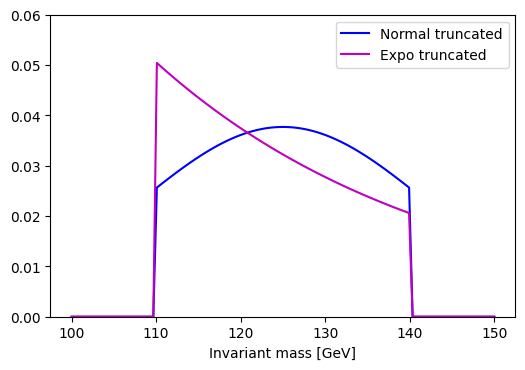

In [245]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [8]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [9]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

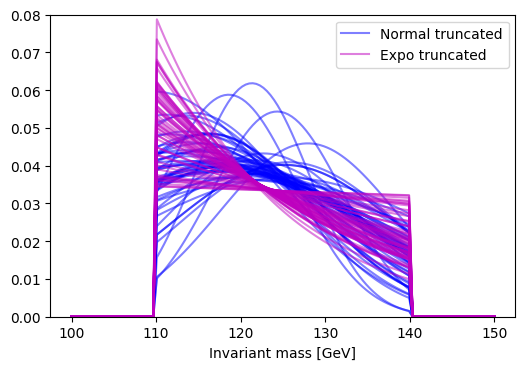

In [246]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

## Generate synthetic data

In [418]:
b=30
Lambda = 0.06
mu=120
sigma=7
###################
data = []
p = [0.7,0.3]
np.random.seed(seed=0)
for i in range(5000):
    if np.random.binomial(1,p[0], size=1)[0]:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
    else:
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])

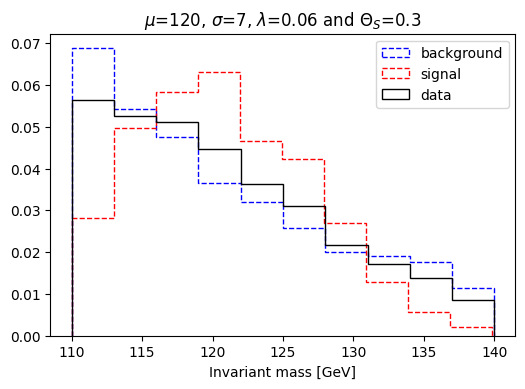

In [419]:
plt.hist([x[1] for x in data if x[2]==0], histtype='step', linestyle='dashed', color='blue', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', linestyle='dashed', color='red',  density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.xlabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

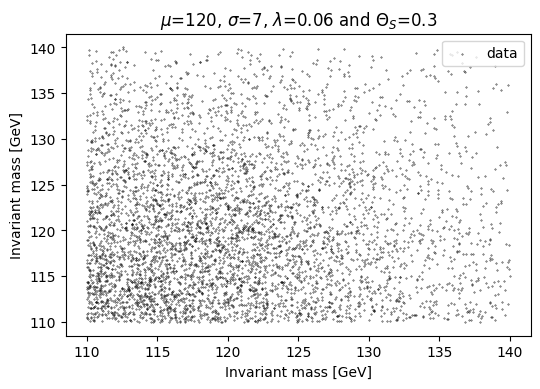

In [420]:
plt.scatter([x[0] for x in data], [x[1] for x in data], color='black', s=0.1, label='data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

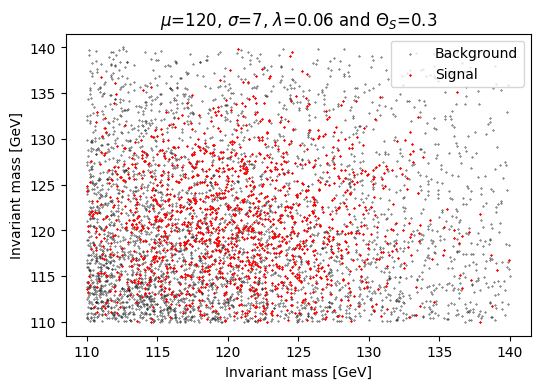

In [421]:
plt.scatter([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], color='black', s=0.1, label='Background')
plt.scatter([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], color='red', marker='x', s=0.5, label='Signal')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

## Stan inference

In [422]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 real L, U; // lower and upper limits of the observables (i.e. how to truncate the distributions)
 array[N,2] real<lower=L, upper=U> y;  // there are 2 observables per datapoint
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;  // hyperparameters for the parameters priors
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
     lp[1] =   normal_lpdf(y[n,1] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) )             
             + normal_lpdf(y[n,2] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) );
     lp[2] =   exponential_lpdf( y[n,1] - L | lambda0)             
             - exponential_lcdf( U - L | lambda0) 
             + exponential_lpdf( y[n,2] - L| lambda0)
             - exponential_lcdf( U - L | lambda0);
     target += log_mix(theta, lp);                        
     };
}
"""

In [432]:
# Define hyperparameters that determine priors
mu0 = 120
sigma0 = 6
mu1 = 8
sigma1 =5
mu2 = Lambda*0.8
sigma2 = Lambda*0.2       
t1 = 1
t2 = 1

In [424]:
passed_data = [[x[0], x[1]] for x in data]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2,
           'L' : 110.0,
           'U' : 140.0
          }

In [425]:
model = stan.build(my_model, data=my_data, random_seed=0);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_7jtvbb2i/model_pjdfqo2o.stan', line 21, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [426]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.95)


Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: log_mix: lambda[1] is inf, but must be finite! (in '/tmp/httpstan_512xjif_/model_pjdfqo2o.stan', line 32, column 5 to column 34)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: log_mix: lambda[1] is inf, but must be finite! (in '/tmp/httpstan_512xjif_/model_pjdfqo2o.stan', line 32, column 5 to column 34)
  Gradient evaluation took 0.006269 seconds
  1000 transitions using 10 leapfrog steps per transition would take 62.69 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: exponential_lcdf: Inverse scale parameter is 0, but must be positive finite! (in '/tmp/httpstan_512xjif_/model_pjdfqo2o.stan', line 28, column 5 to line 31, column 50)
  

## Analyze results

In [427]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,lambda0,theta.1,theta.2
draws,,,,,,,,,,,,
0,-32598.734453,0.994393,0.176560,3.0,11.0,0.0,32600.239461,120.773958,6.188426,0.063815,0.242102,0.757898
1,-32601.510781,0.808358,0.149106,4.0,15.0,0.0,32604.731098,115.727014,10.256436,0.059067,0.569648,0.430352
2,-32597.717577,0.973526,0.137055,3.0,7.0,0.0,32599.468725,120.248254,6.372511,0.064067,0.253136,0.746864
3,-32597.238541,0.998011,0.141012,4.0,27.0,0.0,32599.385174,119.383923,7.435660,0.061015,0.316427,0.683573
4,-32598.284739,0.988675,0.176560,4.0,15.0,0.0,32600.078479,119.809050,6.475248,0.061148,0.238525,0.761475
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-32598.334885,0.981999,0.141012,3.0,15.0,0.0,32599.493393,119.554985,7.485811,0.063616,0.282779,0.717221
3996,-32597.761548,0.991881,0.176560,3.0,11.0,0.0,32601.363552,119.822534,7.038930,0.065274,0.295709,0.704291
3997,-32599.158008,0.983236,0.149106,4.0,31.0,0.0,32600.629565,119.641336,6.495701,0.058343,0.271965,0.728035


In [428]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,118.861,1.320,116.425,120.933,0.055,0.039,691.0,570.0,1.01
sigma,7.770,1.120,5.868,9.878,0.046,0.033,660.0,702.0,1.01
lambda0,0.062,0.004,0.054,0.069,0.000,0.000,1114.0,842.0,1.00
theta[0],0.348,0.089,0.200,0.505,0.004,0.003,630.0,678.0,1.01
theta[1],0.652,0.089,0.495,0.800,0.004,0.003,630.0,678.0,1.01


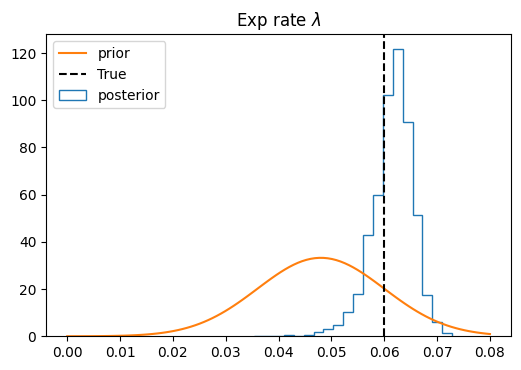

In [429]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.title('Exp rate $\lambda$')
plt.legend()
plt.show()

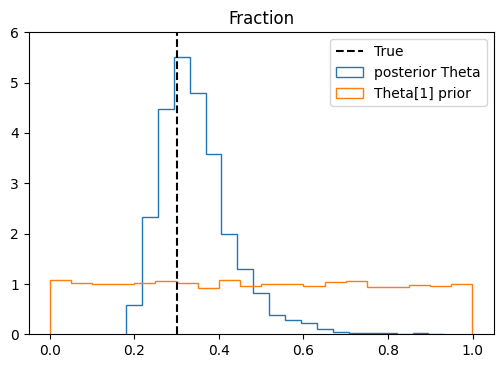

In [431]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.1'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
#plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=p[1], linestyle='dashed', color='black', label='True')
plt.ylim(0,6)
plt.title('Fraction')
plt.legend()
plt.show()

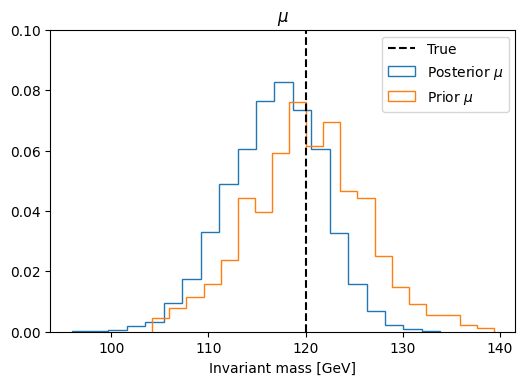

In [415]:
x=np.linspace(100,150,100)
plt.hist(df['mu'], histtype='step', density=1, bins=20, label='Posterior $\mu$')
plt.hist([x for x in np.random.normal(mu0,sigma0,size=500)], density=1, histtype='step', bins=20, label='Prior $\mu$')
plt.axvline(x=mu, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.1)
plt.title('$\mu$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

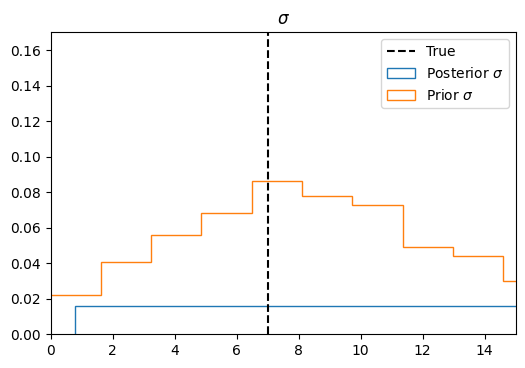

In [416]:
x=np.linspace(0,15,100)
plt.hist(df['sigma'], histtype='step', density=1, bins=30, label='Posterior $\sigma$')
plt.hist([x for x in np.random.normal(mu1,sigma1,size=1500)], density=1, histtype='step', bins=20, label='Prior $\sigma$')
plt.axvline(x=sigma, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.17)
plt.xlim(0,15)
plt.title('$\sigma$')
plt.legend()
plt.show()